In [1]:
import os

In [2]:
import shutil

In [5]:
nnunet_results = './nnUNet_results'

In [3]:
from tqdm import tqdm

In [4]:
import json

In [5]:
import numpy as np

In [14]:
dataset = 'Dataset'
for fold in tqdm(os.listdir(nnunet_results)):
    if dataset in fold:
        new_fold = fold.replace('Dataset0','Task')
        test_files_fold = f'./nnUNet_results/{fold}/nnUNetTrainer_501epochs__nnUNetPlans__3d_fullres_resenc_96_bs24/fold_0/test'
        new_test_files_fold = os.path.join(nnunet_results,'send_msd_gc',new_fold)
        print(new_fold)
        # print(test_files_fold)
        # print(new_test_files_fold)
        shutil.copytree(test_files_fold,new_test_files_fold)


  0%|                                                     | 0/7 [00:00<?, ?it/s]

Task09_Spleen
Task07_Pancreas


 29%|████████████▊                                | 2/7 [00:00<00:00,  5.10it/s]

Task08_HepaticVessel


 71%|████████████████████████████████▏            | 5/7 [00:00<00:00,  6.01it/s]

Task10_Colon
Task06_Lung


 86%|██████████████████████████████████████▌      | 6/7 [00:01<00:00,  6.28it/s]

Task03_Liver


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


In [18]:
## copying validation files to a new folder for liver cause it will take more time than requried.
#first get the splits file and find the validation file
splits_file = './nnUNet_preprocessed/Dataset003_Liver/splits_final.json'

In [19]:
with open(splits_file,'r') as file:
    data = json.load(file)

In [21]:
liver_val_files = data[0]['val']

In [22]:
liver_imagesTr = './nnUNet_raw/Dataset003_Liver/imagesTr'
liver_labelsTr = './nnUNet_raw/Dataset003_Liver/labelsTr'

In [33]:
liver_imagesVal = liver_imagesTr.replace('imagesTr','imagesVal')

In [35]:
liver_imagesVal

'./nnUNet_raw/Dataset003_Liver/imagesVal'

In [34]:
if not os.path.exists(liver_imagesVal):
    os.makedirs(liver_imagesVal)

In [36]:
for file in os.listdir(liver_labelsTr):
    file_name = file.split('.')[0]
    #print(file_name)
    if file_name in liver_val_files:
        #source image
        source_image = os.path.join(liver_imagesTr,file_name+'_0000.nii.gz')
        dst_image = os.path.join(liver_imagesVal,file_name+'_0000.nii.gz')
        shutil.copy(source_image,dst_image)

In [37]:
#Plots for SwinUNETR based models

In [6]:
import torch
from torch.utils.tensorboard.summary import hparams
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd
import os

In [7]:
def load_tensorboard_data(event_file,tags):

    data = {tag: [] for tag in tags}

    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    for tag in tags:

        if tag in event_acc.Tags()['scalars']:
            events = event_acc.Scalars(tag)
            data[tag].extend((event.step,event.value) for event in events)

    return data

In [8]:
def smooth_data(data,window_size = 5):
    return pd.Series(data).rolling(window = window_size,center=True).mean()

In [9]:
def plot_variables(data,title='Tensorboard Variables',highlight_tag='train_dice_loss'):

    plt.figure(figsize = (12,6))

    for tag,values in data.items():
        if values:
            df = pd.DataFrame(values,columns = ['step','value'])
            df = df.sort_values('step')
            if tag == highlight_tag:
                plt.plot(df['step'],df['value'],label = tag,color = 'red',zorder=10)
            elif tag is not None:
                label = tag[16:]
                plt.plot(df['step'],df['value'],label = label,alpha = 0.7)
        else:
            print(f' NO data found for tag : {tag}')

    plt.title(title)
    plt.xlabel('step')
    plt.ylabel('value')
    plt.legend(
        #loc = 'upper left',
        prop = {'size':8},
        #bbox_to_anchor = (0.98,0.02),
        borderaxespad=0.
    )
    plt.grid(True)
    plt.show()

In [10]:
def plot_variables_2(data,title='Tensorboard Variables',window_size=5,highlight_tag='train_dice_loss'):

    plt.figure(figsize = (12,6))

    for tag,values in data.items():
        if values:
            df = pd.DataFrame(values,columns = ['step','value'])
            sm_data = smooth_data(df['value'],window_size)
            if tag == highlight_tag:
                plt.plot(df['step'],sm_data,label = tag,color = 'red',zorder=10)
            elif tag is not None:
                label = tag[16:]
                plt.plot(df['step'],sm_data,label = label,alpha = 0.7)
        else:
            print(f' NO data found for tag : {tag}')

    plt.title(title)
    plt.xlabel('step')
    plt.ylabel('value')
    plt.legend(
        #loc = 'upper left',
        prop = {'size':8},
        #bbox_to_anchor = (0.98,0.02),
        borderaxespad=0.
    )
    plt.grid(True)
    plt.show()

In [11]:
def tags_to_plot(logdir,tags,model_name):

    data = load_tensorboard_data(logdir,tags)
    if data:
        plot_variables(data,f'training_metrics for {model_name}')
    else:
        print(f'error loading tensorboard for {logdir}')

In [12]:
def tags_to_plot_2(logdir,tags,model_name,window_size=5):

    data = load_tensorboard_data(logdir,tags)
    if data:
        plot_variables_2(data,f'training_metrics for {model_name}',window_size)
    else:
        print(f'error loading tensorboard for {logdir}')

In [13]:
ORGAN_NAME = ['Spleen','Liver','Pancreas','Hepatic Vessel','Liver Tumor','Pancreas Tumor','Hepatic Vessel Tumor','Lung Tumor','Colon Tumor']

In [120]:
film_event_file = './out/train_val_film_bs4/events.out.tfevents.1724872701.c1100a-s17.ufhpc.2671886.0'
tags= ['train_dice_loss']
tags.extend([f'Dice Score Class {organ}' for organ in ORGAN_NAME])

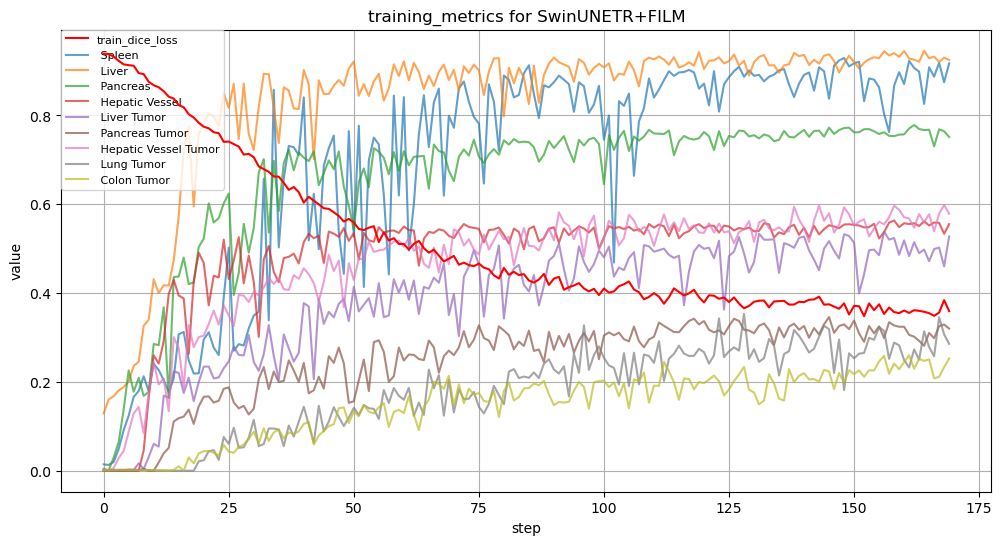

In [121]:
tags_to_plot(film_event_file,tags,'SwinUNETR+FILM')

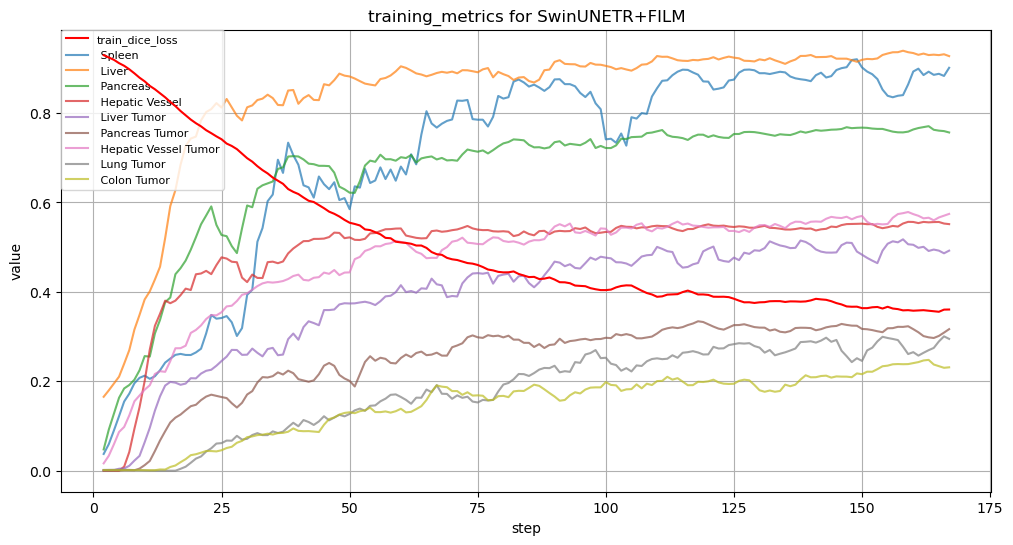

In [136]:
film_event_file = './out/train_val_film_bs4/events.out.tfevents.1724872701.c1100a-s17.ufhpc.2671886.0'
tags= ['train_dice_loss']
tags.extend([f'Dice Score Class {organ}' for organ in ORGAN_NAME])
tags_to_plot_2(film_event_file,tags,'SwinUNETR+FILM',5)

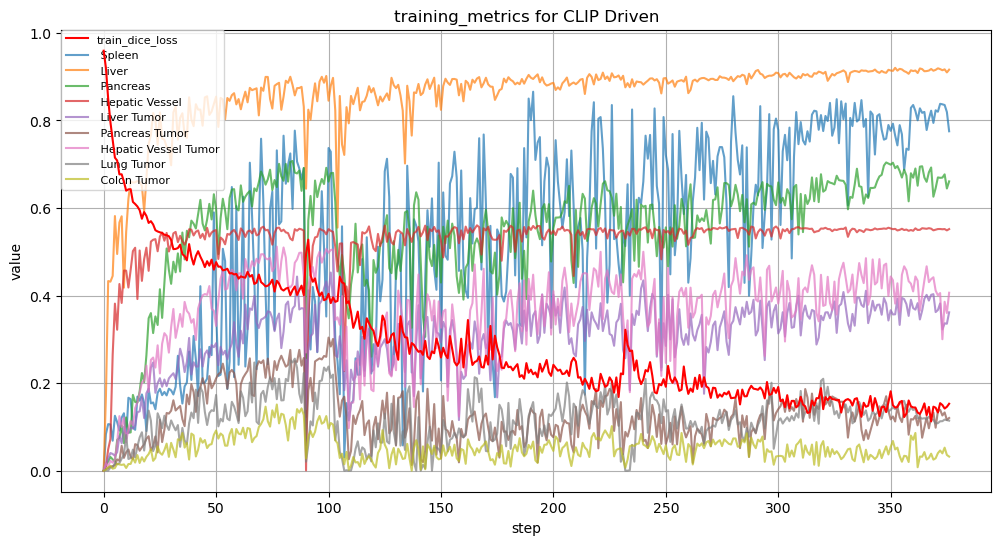

In [15]:
film_event_file = './out/train_val_clip_1/events.out.tfevents.1724946593.c0903a-s23.ufhpc.1540631.0'
tags= ['train_dice_loss']
tags.extend([f'Dice Score Class {organ}' for organ in ORGAN_NAME])
tags_to_plot(film_event_file,tags,'CLIP Driven')

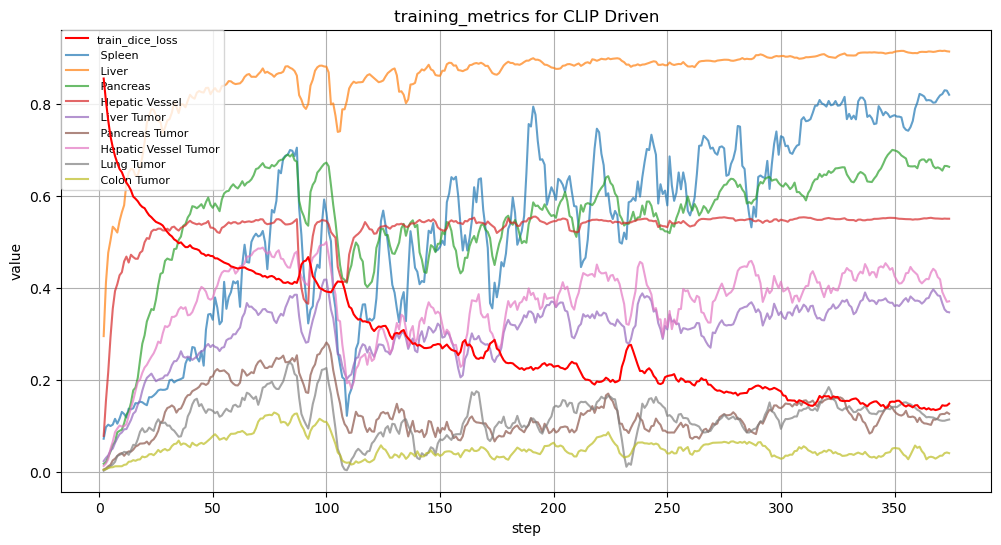

In [14]:
film_event_file = './out/train_val_clip_1/events.out.tfevents.1724946593.c0903a-s23.ufhpc.1540631.0'
tags= ['train_dice_loss']
tags.extend([f'Dice Score Class {organ}' for organ in ORGAN_NAME])
tags_to_plot_2(film_event_file,tags,'CLIP Driven')

In [161]:
dic_fold_files = {}

In [173]:
#get list of all the files for training and validation from his folder
gong_fold = '/blue/kgong/gongyuxin/Dataset130_Autopet_class'
for fold in os.listdir(gong_fold):
    if fold in ['labelsTr','imagesTr','imagesVa','labelsVa']:
        if fold[-2:] == 'Tr':
            fold_path = os.path.join(gong_fold,fold)
            if fold[:6] =='images':
                
                for subfold in os.listdir(fold_path):
                    key1 = os.path.join(fold,subfold,fold+'_modality1')
                    key2 = os.path.join(fold,subfold,fold+'_modality2')
                    print(key1,key2)
                    dic_fold_files[key1] = [f for f in os.listdir(os.path.join(gong_fold,key1)) if f.endswith('.nii.gz')]
                    dic_fold_files[key2] = [f for f in os.listdir(os.path.join(gong_fold,key2)) if f.endswith('.nii.gz')]
                    
            elif fold[:6] == 'labels':
            
                for subfold in os.listdir(fold_path):
                    key = os.path.join(fold,subfold)
                    print(key)
                    dic_fold_files[key] = [f for f in os.listdir(os.path.join(gong_fold,key)) if f.endswith('.nii.gz')]
                    
        elif fold[-2:] == 'Va':

            if fold[:6] =='images':
                
                key1 = os.path.join(fold,fold+'_modality1')
                key2 = os.path.join(fold,fold+'_modality2')
                print(key1,key2)
                dic_fold_files[key1] = [f for f in os.listdir(os.path.join(gong_fold,key1)) if f.endswith('.nii.gz')]
                dic_fold_files[key2] = [f for f in os.listdir(os.path.join(gong_fold,key2)) if f.endswith('.nii.gz')]
            
            elif fold[:6] == 'labels':
            
                
                key = os.path.join(fold)
                print(key)
                dic_fold_files[key] = [f for f in os.listdir(os.path.join(gong_fold,key)) if f.endswith('.nii.gz')]

labelsTr/positive_samples_labels
labelsTr/negative_samples_labels
imagesTr/positive_samples_images/imagesTr_modality1 imagesTr/positive_samples_images/imagesTr_modality2
imagesTr/negative_samples_images/imagesTr_modality1 imagesTr/negative_samples_images/imagesTr_modality2
labelsVa
imagesVa/imagesVa_modality1 imagesVa/imagesVa_modality2


In [178]:
#creating reverse_mapping 
gib_patient = {prop['patient_id'].replace('.npy','.nii.gz'):key for key,prop in patient_data.items()}

In [198]:
prop['patient_id']

'psma_3561d942a56d7096_2017-02-04.npy'

In [138]:
#use here only to convert the dataset into the required format. 

In [145]:
parent_folder = '/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/'

In [146]:
patient_json = os.path.join(parent_folder,'patient.json')

In [147]:
with open(patient_json,'r') as jfile:
    patient_data = json.load(jfile)

In [148]:
len(patient_data)

1611

In [149]:
labels_fold = os.path.join(parent_folder,'preprocessed_labels')
images_fold = os.path.join(parent_folder,'preprocessed_images')

In [174]:
for fold,files in dic_fold_files.items():
    fold_path = os.path.join(parent_folder,fold)
    if os.path.exists(fold_path):
        print(fold_path,'yes')
    else:
        print(fold_path,'no')

/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/labelsTr/positive_samples_labels yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/labelsTr/negative_samples_labels yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/imagesTr/positive_samples_images/imagesTr_modality1 yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/imagesTr/positive_samples_images/imagesTr_modality2 yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/imagesTr/negative_samples_images/imagesTr_modality1 yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/imagesTr/negative_samples_images/imagesTr_modality2 yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/labelsVa yes
/blue/kgong/s.kapoor/uni-seg/UniSeg/Upstream/nnUNet_preprocessed/Dataset130_Autopet3/imagesVa/

In [217]:
for fold,files in dic_fold_files.items():
    if 'labels' in fold:
        
        print(fold)
        label_path = os.path.join(parent_folder,fold)
        image_path = os.path.join(parent_folder,fold.replace('labels','images'))
        #print(label_path,image_path)
        for file in tqdm(files):
            patient_name = gib_patient[file]
            #transfer from preprocessed_labels to labelva
            source_label_path = os.path.join(labels_fold,patient_name)
            dst_label_path = os.path.join(label_path,file.replace('.nii.gz','.npy'))
            source_image_path = os.path.join(images_fold,patient_name) 
            #print(patient_name)
            #print(source_label_path)
            #print(dst_label_path)
            #print(source_image_path)
            modal1_path = os.path.join(image_path,f'images{fold[6:8]}_modality1',file.replace('.nii.gz','_0000.npy'))
            modal2_path = os.path.join(image_path,f'images{fold[6:8]}_modality2',file.replace('.nii.gz','_0001.npy'))
            #print(modal1_path)
            #print(modal2_path)
            #open the .npy file and get its shape
            image = np.load(source_image_path)
            image1 = np.expand_dims(image[0],axis=0)
            image2 = np.expand_dims(image[1],axis=0)
            #print(image.shape)
            #print(image1.shape)
            #print(image2.shape)
            #transfer the label
            shutil.copy(source_label_path,dst_label_path)
            #transfer the images in specific modality folder
            np.save(modal1_path,image1)
            np.save(modal2_path,image2)

labelsTr/positive_samples_labels


100%|█████████████████████████████████████████| 900/900 [23:49<00:00,  1.59s/it]


labelsTr/negative_samples_labels


100%|█████████████████████████████████████████| 500/500 [13:57<00:00,  1.67s/it]


labelsVa


100%|███████████████████████████████████████████| 58/58 [01:25<00:00,  1.48s/it]
